# <Center> Homework 5: Classification </center>

This assignment needs the following two data files:
- train.csv: dataset for training
- test.csv: dataset for testing. 
    
Both of them have samples in the following format. The `text` column contains documents and the `label` column gives the sentiment of each document.

|label | text |
|------|------|
|1|  I must admit that I'm addicted to "Version 2.0...|
|0|  I think it's such a shame that an enormous tal...|
|1|  The Sunsout No Room at The Inn Puzzle has oddl...|
|...|...|


## Q1 Classification

- Define a function `create_model(train_docs, train_y, test_docs, test_y, tokenizer=None, model_type='svm', stop_words='english', min_df = 1, print_result = True, algorithm_para=1.0`), where

    - `train_docs`: is a list of documents for training
    - `train_y`: is the ground-truth labels of training documents
    - `test_docs`: is a list of documents for test
    - `test_y`: is the ground-truth labels of test documents
    - `tokenizer`: is the tokenizer and it can be customized by using the lemmatizer of Spacy package
    - `model_type`: two options: `nb` (Multinomial Naive Bayes) or `svm` (Linear SVM)
    - `stop_words`: indicate whether stop words should be removed. The default value is 'english', i.e. remove English stopwords.
    - `min_df`: only word with document frequency above this threshold can be included. The default is 1. 
    - `print_result`: controls whether to show classification report or plots. The default is True.
    - `algorithm_para`: hyperparameter of algorithms, refers to C in SVM and alpha in NB. Both C and alpha have default values of 1.0. Please check sklearn documentation here: https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html
    https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html


- This function does the following:
    - Fit a `TfidfVectorizer` using `train_docs` with options `stop_words, min_df` as specified in the function inputs. Extract features from `train_docs` using the fitted `TfidfVectorizer`.
    - Build `linear SVM` or `Multinomial Naive Bayes` model as specified by `model_type` with `algorithm_para` setting. Train the model using the extracted features and `train_y`. 
    - Transform `test_docs` by the fitted `TfidfVectorizer` (hint: use function `transform` not `fit_transform`).
    - Predict the labels for `test_docs`. If `print_result` is True, print the classification report.
    - Calculate the AUC score and PRC score (or Average Precision) for class 1 on the test dataset. If `print_result` is True, plot the ROC and PRC curves. **Hint**: 
        - `sklearn.svm.LinearSVM` does not provide `predict_proba` function. 
        - Instead, you can use its `decision_function` (see <a href = "https://stackoverflow.com/questions/59227176/how-to-plot-roc-and-calculate-auc-for-binary-classifier-with-no-probabilities-s">some reference code</a>) 
        - Another option is to use `sklearn.svm.SVC` with `kernel='linear' and probability=False` (see <a href = "https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html"> reference</a>)
    - Return the AUC and PRC scores.

    
- Test your function with following cases:
    - model_type='svm', stop_words = 'english', min_df = 1
    - model_type='nb', stop_words = 'english', min_df = 1

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_curve, auc,precision_recall_curve
from sklearn.metrics import classification_report
from matplotlib import pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

train = pd.read_csv("train5.csv")
test = pd.read_csv("test5.csv")
# get portion to reduce processing time
train=train.iloc[0:5000]
test=test.iloc[0:5000]

In [15]:
# define the customized tokenizer using spacy package
# you can also use stanza package
# this function tokenize the text and get lemmas

import nltk
import spacy

nlp = spacy.load("en_core_web_sm")


def MyTokenizer(text):
    #text = train["text"][0]
    tokenized = []
    doc = nlp(text)
    for token in doc:
        tokenized.append(token.lemma_)
    return tokenized

In [59]:
# Define the function for Task 1
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve

def create_model(train_docs, train_y, test_docs, test_y, tokenizer=None,
                 model_type="svm", min_df = 1,stop_words=None, 
                 print_result = True, algorithm_para=1.0):
    
    feature = TfidfVectorizer()
    feature.set_params(stop_words = stop_words, min_df = min_df)
    
    xfeatures = feature.fit_transform(train_docs)
    if model_type == 'svm':
        model = SVC(probability=True, kernel='linear')
        model.fit(xfeatures, train_y)
    else:
        model = MultinomialNB()
        model.fit(xfeatures, train_y)
    
    test_x_features = feature.transform(test_docs)

    predictions = model.predict_proba(test_x_features)
    
    auc_score = roc_auc_score(test_y, predictions[:,1])
    prc_score = average_precision_score(test_y, predictions[:,1])
    
    if print_result:
        
        print("AUC:", auc_score, " PRC:", prc_score)
        
        test_fpr, test_tpr, te_thresholds = roc_curve(test_y, predictions[:,1])
        plt.grid()
        plt.plot(test_fpr, test_tpr)
        plt.plot([0,1],[0,1],'g--')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("AUC(ROC curve)")
        plt.grid(color='black', linestyle='-', linewidth=0.5)
        plt.show()
        
        prec, recall, thresh = precision_recall_curve(test_y, predictions[:,1])
        plt.grid()
        plt.plot(recall, prec)
        plt.plot([0,1],[0,1],'g--')
        plt.xlabel("Precision")
        plt.ylabel("Recall")
        plt.title("PRC curve")
        plt.grid(color='black', linestyle='-', linewidth=0.5)
        plt.show()
    return auc_score, prc_score

    

AUC: 0.9075700526970737  PRC: 0.9122290428732341


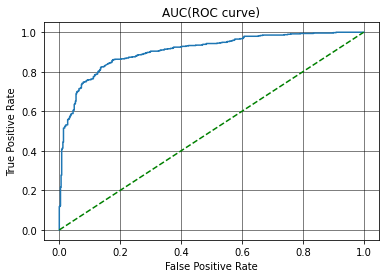

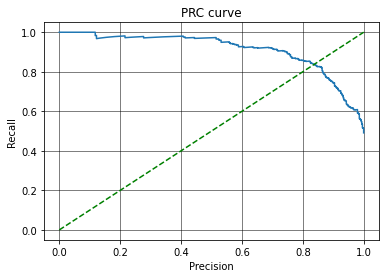

AUC: 0.9075680520488638  PRC: 0.912242465557635


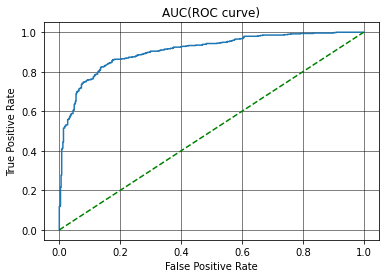

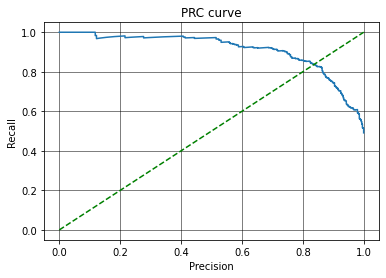

In [60]:
# Test the function with 'svm'
# Compare the default tokenizer and customized tokenizer
# Explain your finding

auc_score, prc_socre = create_model(train["text"], train["label"], test["text"], test["label"], \
            tokenizer=None,model_type='svm',  min_df = 1, stop_words=None, \
                                    print_result=True, algorithm_para=1.0)

auc_score, prc_socre = create_model(train["text"], train["label"], test["text"], test["label"], \
            tokenizer=MyTokenizer,model_type='svm', min_df = 1, stop_words=None, \
                                    print_result=True, algorithm_para=1.0)

#The default vectorizer is better than my tokenizer although both output reasonable values.

AUC: 0.8855389146083332  PRC: 0.886872471182463


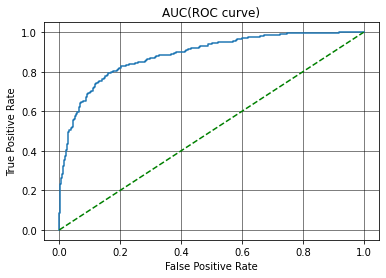

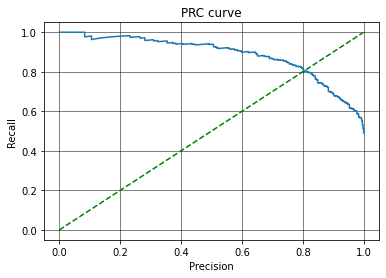

AUC: 0.8855389146083332  PRC: 0.886872471182463


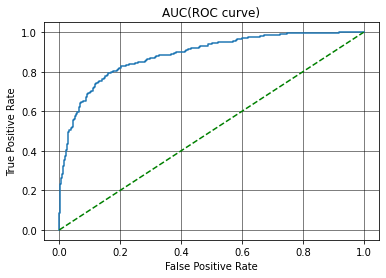

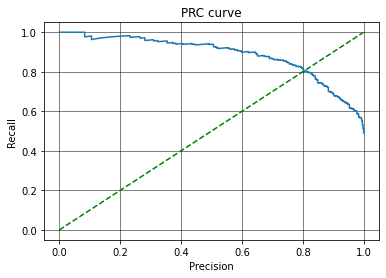

In [61]:
# Test the function with 'nb' 
# Compare the default tokenizer and customized tokenizer
# Explain your finding

auc_score, prc_socre = create_model(train["text"], train["label"], test["text"], test["label"], \
            tokenizer=MyTokenizer,model_type='nb',  min_df = 1, stop_words=None, \
                                    print_result=True, algorithm_para=1.0)



auc_score, prc_socre = create_model(train["text"], train["label"], test["text"], test["label"], \
            tokenizer=None,model_type='nb', min_df = 1, stop_words=None, \
                                    print_result=True, algorithm_para=1.0)
#The naive bayes is overall worse than SVM but not by much the default tokenizer is better for NB too.

### Task 2: Search for best parameters 

From Task 1, you may find there are many possible ways to configure parameters. Next, let's use grid search to find the optimal parameters

- Define a function `search_para(docs, y)` where `docs` are training documents and `y` is the ground-truth labels.
- This function does the following:
    - Create a pipleline which integrates `TfidfVectorizer` and `SVM` classifier 
    - Define the parameter ranges as follow:
        - `stop_words': [None, 'english']`
        - `min_df: [1,2,5]`
        - `C: [0.1,0.5,1]`
    - Set the scoring metric to "f1_macro"
    - Use `GridSearchCV` with `5-fold cross validation` to find the best parameter values based on the training dataset. 
    - Print the best parameter values
    
- Call the function `svm_model` defined in Task 1 (default tokenizer) `with the best parameter values`. You will have to add the best C value to the original function, because you used default settings of the SVM classifier previously. Then please briefly answer the following:
    - Compare with the model in Task 1, how is the performance improved on the test dataset?
    - Why do you think the new parameter values help sentiment classification?

In [98]:
# Define grade search function
from sklearn.model_selection import GridSearchCV
def search_para(docs, y):
    
    text_clf_svc = Pipeline([('tfidf', TfidfVectorizer()), ('clf', SVC(kernel = 'linear' ,probability = True,))])
    
#     feature = TfidfVectorizer()
#     xfeatures = feature.fit_transform(docs)

#     model = SVC(probability=True, kernel='linear')
#     model.fit(xfeatures, y)
    
    parameters = {'tfidf__stop_words': [None, 'english'], 'clf__C':[0.1,0.5,1], 'tfidf__min_df': [1,2,5]}
    final = GridSearchCV(text_clf_svc, parameters)
    final.fit(docs, y)
    print(final.best_score_)
    print(final.best_estimator_)
    print(final.best_params_)
    
    # Add your code here


In [99]:
search_para(train["text"], train["label"])
#Takes a long time to run

0.8442500000000001
Pipeline(steps=[('tfidf', TfidfVectorizer(min_df=5)),
                ('clf', SVC(C=0.5, kernel='linear', probability=True))])
{'clf__C': 0.5, 'tfidf__min_df': 5, 'tfidf__stop_words': None}


AUC: 0.9191097915724695  PRC: 0.9163468637499521


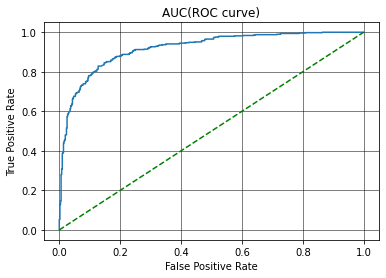

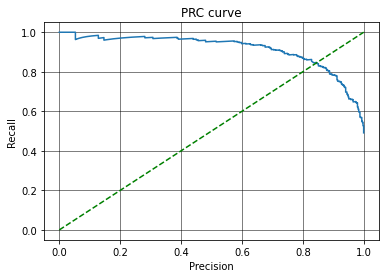

In [100]:
# call the function with the best parameters

auc_score, prc_socre = create_model(train["text"], train["label"], test["text"], test["label"], \
            tokenizer=None, model_type='svm',  min_df = 5, stop_words=None,\
                                    print_result=True, algorithm_para=0.5)
# Please answer the questions
# The performance is slightly better in the test data set with the updated parameters. 

#The new parameter values help sentiement classification because they create slight optimization for the data we have.
#These optimization end up playing a larger role in the final accuracy test.

## Task 3. How many samples are enough? 

This task is to help you understand the impact of sample size on classifier performance. 

- Define a function `sample_size_impact(train_docs, train_y, test_docs, test_y)` with the input as defined above. 
    
    
- This function does the following:
    - Starting with 500 samples, in each round you build a classifier with 500 more samples. i.e. in round 1, you use samples from 0:500, and in round 2, you use samples from 0:1000, …, until you use all samples. 
    - In each round, call the `create_model` function with `model_type='svm'` and  `model_type='nb'` and `stop_words='english'`. Keep other parameters as default. Record the AUC score of each model type and the sample size.
    - For each model type, plot a line chart show the relationship between sample size and the AUC score. 
    - This function has no return.
    
    
- Write your analysis on the following:
    - How sample size affects each classifier’s performance? 
    - If it is expensive to collect and label samples, can you decide an optimal sample size with model performance and the cost of samples both considered? 
    - How is performance of SVM classifier compared with Naïve Bayes classifier?

In [96]:
# Show the impact of sample size

def sample_size_impact(train_docs, train_y, test_docs, test_y):  
    samples = [500,1000,1500,2000,2500,3000,3500,4000,4500,5000,5500,6000,6500,7000,7500,8000,8500,9000,10000,10500,11000,11500,12000]
    svmOut = []
    nbOut = []
    #print(len(train_docs))
    
    for samp in samples:
        auc_score, prc_socre = create_model(train_docs[:samp], train_y[:samp], test_docs[:samp], test_y[:samp], \
            tokenizer=None ,model_type='nb',  min_df = 5, stop_words=None, \
                                    print_result=False, algorithm_para=1.0)
        nbOut.append(auc_score)
    
        auc_score, prc_socre = create_model(train_docs[:samp], train_y[:samp], test_docs[:samp], test_y[:samp], \
            tokenizer=None ,model_type='svm',  min_df = 5, stop_words=None, \
                                    print_result=False, algorithm_para=1.0)
        svmOut.append(auc_score)

    plt.plot(samples, svmOut)
    plt.xlabel("samples")
    plt.ylabel("AUC Score")
    plt.title("SVM samples")
    plt.show()
    
    plt.plot(samples, nbOut)
    plt.xlabel("samples")
    plt.ylabel("AUC Score")
    plt.title("NB samples")
    plt.show()
    # add your code here

12000


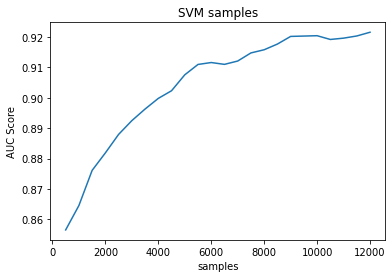

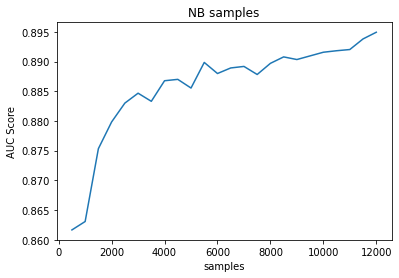

In [97]:
# Test the function

# now we use all the data
train = pd.read_csv("train5.csv")
test = pd.read_csv("test5.csv")

sample_size_impact(train["text"], train["label"], test["text"], test["label"])


# Briefly answer the questions

# A bigger sample size helped the performance of both classifiers. They both had drastic improvements with more samples.

# For the SVM model after about the 10,000 sample mark the return for having more samples is greatly reduced.
# So about 10,000 samples should be enough, however for Naive Bayes the most significant learning was done within
# 5000 samples and then there was slight improvement. While the NB model isn't great at 5000 samples it could be
# efficient to run it with 5000 samples.

# The SVM classifier seems to be better than the NB classifier. It has more consistent improvement and maxes out at
# a higher AUC Score so it is better. 

## Task 4 (Bonus): How to improve sentiment classification?

- Can you tune other parameters of TfidfVectorizer or SVM model to further improve the classification performance? Try to beat the model you get in Task 2!

In [ ]:
 # add your code here